<a href="https://colab.research.google.com/github/TejasVijaya74/localrepo/blob/main/EEG_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Install required packages
!pip install mne h5py numpy matplotlib

# Import necessary libraries
import numpy as np
import mne
import h5py
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries installed successfully!")


✅ Libraries installed successfully!


In [8]:
#from google.colab import files
#import os

# Upload your BDF file
#print(" Please select your BDF file to upload:")
#uploaded = files.upload()

# Get the filename
#bdf_filename = list(uploaded.keys())[0]
#print(f" File uploaded: {bdf_filename}")


In [9]:
import os
print("📁 Files in session storage:")
for file in os.listdir('/content/'):
    print(f"  - {file}")


📁 Files in session storage:
  - .config
  - EEG_Cat_Study4_II_II_S10.bdf
  - sample_data


In [10]:
import os
# Find BDF files in the session storage
bdf_files = [f for f in os.listdir('/content/') if f.endswith('.bdf')]
print("📊 BDF files found:")
for i, file in enumerate(bdf_files):
    print(f"  {i+1}. {file}")

if bdf_files:
    # Use the first BDF file found
    bdf_filename = bdf_files[0]
    print(f"\n✅ Using: {bdf_filename}")
else:
    print("❌ No BDF files found in session storage")


📊 BDF files found:
  1. EEG_Cat_Study4_II_II_S10.bdf

✅ Using: EEG_Cat_Study4_II_II_S10.bdf


In [11]:
def preprocess_bdf_to_h5(input_file, output_file):
    """
    Preprocess BDF EEG data according to LaBraM specifications:
    - Remove non-EEG channels
    - Bandpass filter: 0.1-75 Hz
    - Notch filter: 50 Hz (or 60 Hz for US data)
    - Resample: 200 Hz
    - Convert to μV
    - Save as HDF5
    """

    print(f"🔄 Processing BDF file: {input_file}")

    # Load BDF file
    try:
        raw = mne.io.read_raw_bdf(input_file, preload=True, verbose=False)
        print(f"✅ Successfully loaded BDF file")
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return False

    # Display original file info
    print(f"📊 Original data shape: {raw.get_data().shape}")
    print(f"📊 Original sampling rate: {raw.info['sfreq']} Hz")
    print(f"📊 Original channels: {len(raw.ch_names)}")
    print(f"📊 Recording duration: {raw.times[-1]:.2f} seconds")

    # Remove non-EEG channels (keep only EEG channels)
    print("\n🔧 Selecting EEG channels only...")
    picks = mne.pick_types(raw.info, eeg=True, exclude='bads')

    if len(picks) == 0:
        # If no EEG channels detected, try to identify them manually
        print("⚠️  No EEG channels auto-detected. Trying to identify manually...")
        # For BioSemi, typically exclude Status and trigger channels
        eeg_channels = [ch for ch in raw.ch_names if not ch.startswith('Status')
                       and not ch.startswith('Trigger') and not ch.startswith('GSR')]
        raw.pick_channels(eeg_channels)
        print(f"✅ Selected {len(eeg_channels)} EEG channels")
    else:
        raw.pick(picks)
        print(f"✅ Selected {len(picks)} EEG channels")

    # Set average reference
    print("🔧 Setting average reference...")
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()

    # Apply bandpass filter (0.1-75 Hz)
    print("🔧 Applying bandpass filter: 0.1-75 Hz...")
    raw.filter(l_freq=0.1, h_freq=75, method='fir', verbose=False)

    # Apply notch filter (50 Hz - change to 60 Hz if US data)
    print("🔧 Applying notch filter: 50 Hz...")
    raw.notch_filter(freqs=50, method='fir', verbose=False)

    # Resample to 200 Hz
    if raw.info['sfreq'] != 200:
        print(f"⚡ Resampling from {raw.info['sfreq']} Hz to 200 Hz...")
        raw.resample(200, verbose=False)
    else:
        print("✅ Already at 200 Hz sampling rate")

    # Convert to μV (microvolts)
    print("🔧 Converting to microvolts (μV)...")
    data = raw.get_data() * 1e6  # Convert from V to μV

    # Save as HDF5
    print(f"💾 Saving preprocessed data to: {output_file}")
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('eeg_data', data=data, compression='gzip')
        f.create_dataset('sfreq', data=200.0)
        f.create_dataset('ch_names', data=[ch.encode('utf-8') for ch in raw.info['ch_names']])
        f.attrs['unit'] = 'μV'
        f.attrs['preprocessing'] = 'LaBraM_compatible'
        f.attrs['original_sfreq'] = raw.info['sfreq']
        f.attrs['n_channels'] = data.shape[0]
        f.attrs['n_samples'] = data.shape[1]
        f.attrs['duration_seconds'] = data.shape[1] / 200.0

    print(f"✅ Processing complete!")
    print(f"📊 Final data shape: {data.shape}")
    print(f"📊 Final sampling rate: 200 Hz")
    print(f"📊 Final units: μV")
    print(f"📊 Final duration: {data.shape[1]/200.0:.2f} seconds")

    return True


In [12]:
# Set the input and output filenames
input_file = f"/content/{bdf_filename}"  # Your BDF file in session storage
output_file = "preprocessed_eeg_labram.h5"

# Run preprocessing
success = preprocess_bdf_to_h5(input_file, output_file)

if success:
    print("\n🎉 Preprocessing completed successfully!")
    print(f"📁 Output file: {output_file}")
else:
    print("\n❌ Preprocessing failed!")


🔄 Processing BDF file: /content/EEG_Cat_Study4_II_II_S10.bdf
✅ Successfully loaded BDF file
📊 Original data shape: (73, 395008)
📊 Original sampling rate: 256.0 Hz
📊 Original channels: 73
📊 Recording duration: 1543.00 seconds

🔧 Selecting EEG channels only...
✅ Selected 72 EEG channels
🔧 Setting average reference...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
🔧 Applying bandpass filter: 0.1-75 Hz...
🔧 Applying notch filter: 50 Hz...
⚡ Resampling from 256.0 Hz to 200 Hz...
🔧 Converting to microvolts (μV)...
💾 Saving preprocessed data to: preprocessed_eeg_labram.h5
✅ Processing complete!
📊 Final data shape: (72, 308600)
📊 Final sampling rate: 200 Hz
📊 Final units: μV
📊 Final duration: 1543.00 seconds

🎉 Prep

In [13]:
# Verify the preprocessed data
with h5py.File(output_file, 'r') as f:
    print("📊 Preprocessed Data Summary:")
    print(f"   - EEG data shape: {f['eeg_data'].shape}")
    print(f"   - Sampling rate: {f['sfreq'][()]} Hz")
    print(f"   - Number of channels: {f.attrs['n_channels']}")
    print(f"   - Duration: {f.attrs['duration_seconds']:.2f} seconds")
    print(f"   - Units: {f.attrs['unit']}")
    print(f"   - Preprocessing: {f.attrs['preprocessing']}")
    print(f"   - Channel names: {[ch.decode('utf-8') for ch in f['ch_names'][:5]]}...")  # First 5 channels

# Download the processed file
from google.colab import files
files.download(output_file)
print(f"📥 Downloaded: {output_file}")


📊 Preprocessed Data Summary:
   - EEG data shape: (72, 308600)
   - Sampling rate: 200.0 Hz
   - Number of channels: 72
   - Duration: 1543.00 seconds
   - Units: μV
   - Preprocessing: LaBraM_compatible
   - Channel names: ['Fp1', 'AF7', 'AF3', 'F1', 'F3']...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloaded: preprocessed_eeg_labram.h5


In [14]:
# Add this to your Google Colab notebook
import numpy as np
import h5py
import matplotlib.pyplot as plt

def segment_eeg_data(h5_file, window_size_seconds=8, overlap_ratio=0.5):
    """
    Segment EEG data into overlapping windows for training

    Args:
        h5_file: Path to your preprocessed HDF5 file
        window_size_seconds: Size of each window in seconds (default: 8s)
        overlap_ratio: Overlap between windows (default: 0.5 = 50%)

    Returns:
        segmented_data: Array of shape (n_windows, n_channels, n_samples)
    """

    with h5py.File(h5_file, 'r') as f:
        eeg_data = f['eeg_data'][:]
        sfreq = f['sfreq'][()]

    n_channels, n_samples = eeg_data.shape
    window_samples = int(window_size_seconds * sfreq)
    step_samples = int(window_samples * (1 - overlap_ratio))

    # Calculate number of windows
    n_windows = (n_samples - window_samples) // step_samples + 1

    # Create segmented data
    segmented_data = np.zeros((n_windows, n_channels, window_samples))

    for i in range(n_windows):
        start_idx = i * step_samples
        end_idx = start_idx + window_samples
        segmented_data[i] = eeg_data[:, start_idx:end_idx]

    print(f"✅ Segmented into {n_windows} windows")
    print(f"📊 Window size: {window_size_seconds}s ({window_samples} samples)")
    print(f"📊 Overlap: {overlap_ratio*100}%")
    print(f"📊 Final shape: {segmented_data.shape}")

    return segmented_data

# Run segmentation
segmented_data = segment_eeg_data('preprocessed_eeg_labram.h5')



✅ Segmented into 384 windows
📊 Window size: 8s (1600 samples)
📊 Overlap: 50.0%
📊 Final shape: (384, 72, 1600)


In [15]:
def create_labram_patches(segmented_data, patch_size=200):
    """
    Create patches compatible with LaBraM architecture

    Args:
        segmented_data: Segmented EEG data (n_windows, n_channels, n_samples)
        patch_size: Size of each patch in samples (default: 200)

    Returns:
        patches: Patches ready for LaBraM training
    """

    n_windows, n_channels, n_samples = segmented_data.shape
    n_patches_per_window = n_samples // patch_size

    # Only use complete patches
    usable_samples = n_patches_per_window * patch_size

    # Reshape to create patches
    patches = segmented_data[:, :, :usable_samples].reshape(
        n_windows, n_channels, n_patches_per_window, patch_size
    )

    print(f"✅ Created patches for LaBraM")
    print(f"📊 Patch size: {patch_size} samples")
    print(f"📊 Patches per window: {n_patches_per_window}")
    print(f"📊 Final patch shape: {patches.shape}")

    return patches

# Create patches
patches = create_labram_patches(segmented_data)


✅ Created patches for LaBraM
📊 Patch size: 200 samples
📊 Patches per window: 8
📊 Final patch shape: (384, 72, 8, 200)


In [16]:
def save_training_dataset(patches, output_file='labram_training_dataset.h5'):
    """
    Save the training-ready dataset
    """

    with h5py.File(output_file, 'w') as f:
        # Save patches
        f.create_dataset('patches', data=patches, compression='gzip')

        # Save metadata
        f.attrs['n_windows'] = patches.shape[0]
        f.attrs['n_channels'] = patches.shape[1]
        f.attrs['n_patches_per_window'] = patches.shape[2]
        f.attrs['patch_size'] = patches.shape[3]
        f.attrs['sfreq'] = 200.0
        f.attrs['units'] = 'μV'
        f.attrs['preprocessing'] = 'LaBraM_compatible'
        f.attrs['ready_for_training'] = True

        # Channel information (from your original data)
        channel_names = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']
        f.create_dataset('channel_names', data=[ch.encode('utf-8') for ch in channel_names[:patches.shape[1]]])

    print(f"✅ Training dataset saved: {output_file}")
    return output_file

# Save training dataset
training_file = save_training_dataset(patches)


✅ Training dataset saved: labram_training_dataset.h5


In [17]:
def validate_training_data(training_file):
    """
    Validate the training dataset
    """

    with h5py.File(training_file, 'r') as f:
        patches = f['patches']

        print("📊 Training Dataset Summary:")
        print(f"   - Total windows: {f.attrs['n_windows']}")
        print(f"   - Channels: {f.attrs['n_channels']}")
        print(f"   - Patches per window: {f.attrs['n_patches_per_window']}")
        print(f"   - Patch size: {f.attrs['patch_size']} samples")
        print(f"   - Sampling rate: {f.attrs['sfreq']} Hz")
        print(f"   - Units: {f.attrs['units']}")
        print(f"   - Data shape: {patches.shape}")
        print(f"   - Data type: {patches.dtype}")
        print(f"   - Memory usage: {patches.nbytes / (1024**3):.2f} GB")

        # Check for any issues
        sample_data = patches[:5]  # Sample first 5 windows
        print(f"\n🔍 Data Quality Checks:")
        print(f"   - Min value: {np.min(sample_data):.2f} μV")
        print(f"   - Max value: {np.max(sample_data):.2f} μV")
        print(f"   - Mean value: {np.mean(sample_data):.2f} μV")
        print(f"   - Std value: {np.std(sample_data):.2f} μV")
        print(f"   - Any NaN values: {np.isnan(sample_data).any()}")
        print(f"   - Any infinite values: {np.isinf(sample_data).any()}")

# Validate the data
validate_training_data(training_file)


📊 Training Dataset Summary:
   - Total windows: 384
   - Channels: 72
   - Patches per window: 8
   - Patch size: 200 samples
   - Sampling rate: 200.0 Hz
   - Units: μV
   - Data shape: (384, 72, 8, 200)
   - Data type: float64
   - Memory usage: 0.33 GB

🔍 Data Quality Checks:
   - Min value: -333.63 μV
   - Max value: 472.48 μV
   - Mean value: -0.00 μV
   - Std value: 22.54 μV
   - Any NaN values: False
   - Any infinite values: False


In [18]:
# Download your training-ready dataset
from google.colab import files
files.download(training_file)
print(f"📥 Downloaded: {training_file}")

# Optional: Create a smaller sample for testing
def create_sample_dataset(training_file, n_samples=100):
    """
    Create a smaller sample dataset for testing
    """

    with h5py.File(training_file, 'r') as f:
        patches = f['patches'][:n_samples]

    sample_file = 'labram_sample_dataset.h5'
    with h5py.File(sample_file, 'w') as f:
        f.create_dataset('patches', data=patches, compression='gzip')
        # Copy all attributes
        for key, value in f.attrs.items():
            f.attrs[key] = value
        f.attrs['n_windows'] = n_samples
        f.attrs['is_sample'] = True

    print(f"✅ Sample dataset created: {sample_file}")
    return sample_file

# Create sample dataset
sample_file = create_sample_dataset(training_file)
files.download(sample_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Downloaded: labram_training_dataset.h5
✅ Sample dataset created: labram_sample_dataset.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ All libraries loaded successfully!")


✅ All libraries loaded successfully!


In [20]:
# Load your training dataset
training_file = 'labram_training_dataset.h5'

def load_eeg_data(filename):
    """Load EEG data from HDF5 file"""
    with h5py.File(filename, 'r') as f:
        patches = f['patches'][:]
        sfreq = f.attrs['sfreq']
        n_channels = f.attrs['n_channels']
        n_windows = f.attrs['n_windows']
        patch_size = f.attrs['patch_size']

        # Load channel names if available
        try:
            channel_names = [ch.decode('utf-8') for ch in f['channel_names'][:]]
        except:
            channel_names = [f'Ch{i+1}' for i in range(n_channels)]

    print(f"📊 Data loaded successfully!")
    print(f"   - Shape: {patches.shape}")
    print(f"   - Sampling rate: {sfreq} Hz")
    print(f"   - Channels: {n_channels}")
    print(f"   - Windows: {n_windows}")
    print(f"   - Patch size: {patch_size}")

    return patches, sfreq, channel_names

# Load the data
patches, sfreq, channel_names = load_eeg_data(training_file)


📊 Data loaded successfully!
   - Shape: (384, 72, 8, 200)
   - Sampling rate: 200.0 Hz
   - Channels: 72
   - Windows: 384
   - Patch size: 200


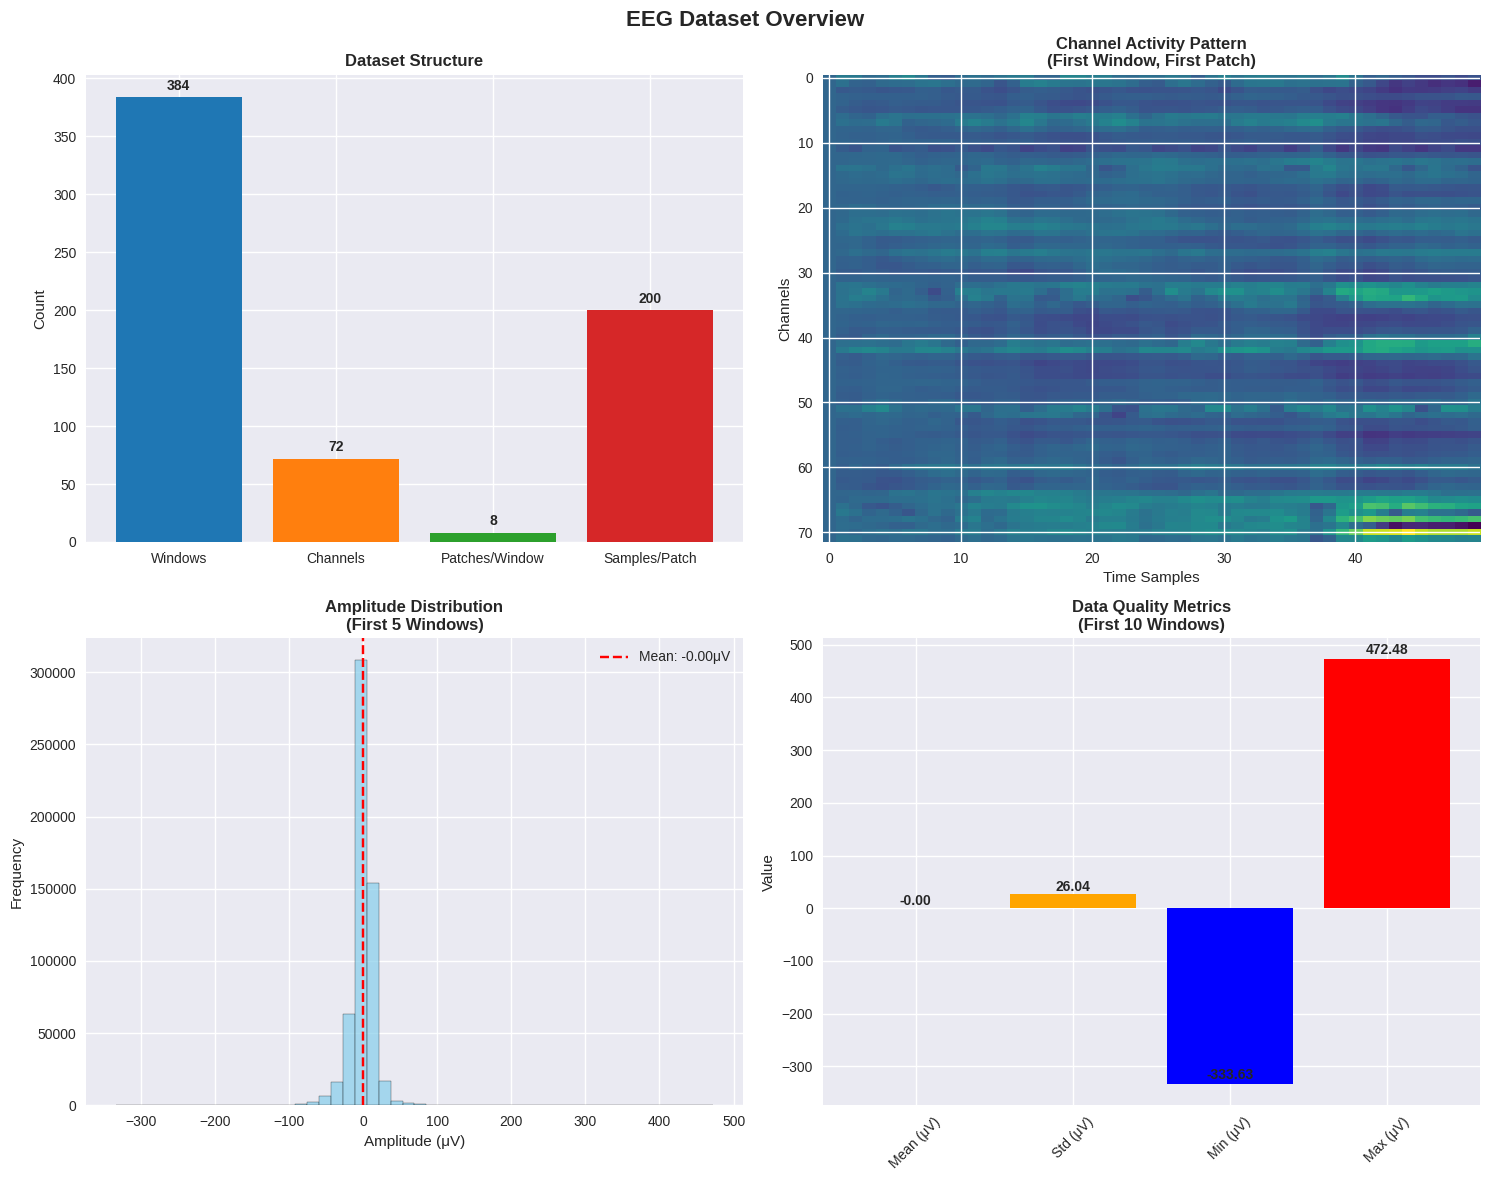

In [21]:
def visualize_data_overview(patches, sfreq, channel_names):
    """Create overview plots of the EEG dataset"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('EEG Dataset Overview', fontsize=16, fontweight='bold')

    # 1. Data shape and structure
    ax1 = axes[0, 0]
    structure_data = {
        'Windows': patches.shape[0],
        'Channels': patches.shape[1],
        'Patches/Window': patches.shape[2],
        'Samples/Patch': patches.shape[3]
    }
    bars = ax1.bar(structure_data.keys(), structure_data.values(),
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax1.set_title('Dataset Structure', fontweight='bold')
    ax1.set_ylabel('Count')

    # Add value labels on bars
    for bar, value in zip(bars, structure_data.values()):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(structure_data.values()),
                f'{value}', ha='center', va='bottom', fontweight='bold')

    # 2. Channel distribution
    ax2 = axes[0, 1]
    sample_data = patches[0, :, 0, :50]  # First window, all channels, first patch, first 50 samples
    ax2.imshow(sample_data, aspect='auto', cmap='viridis')
    ax2.set_title('Channel Activity Pattern\n(First Window, First Patch)', fontweight='bold')
    ax2.set_xlabel('Time Samples')
    ax2.set_ylabel('Channels')

    # 3. Amplitude distribution
    ax3 = axes[1, 0]
    sample_amplitudes = patches[:5].flatten()  # First 5 windows
    ax3.hist(sample_amplitudes, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_title('Amplitude Distribution\n(First 5 Windows)', fontweight='bold')
    ax3.set_xlabel('Amplitude (μV)')
    ax3.set_ylabel('Frequency')
    ax3.axvline(np.mean(sample_amplitudes), color='red', linestyle='--',
                label=f'Mean: {np.mean(sample_amplitudes):.2f}μV')
    ax3.legend()

    # 4. Data quality metrics
    ax4 = axes[1, 1]
    quality_metrics = {
        'Mean (μV)': np.mean(patches[:10]),
        'Std (μV)': np.std(patches[:10]),
        'Min (μV)': np.min(patches[:10]),
        'Max (μV)': np.max(patches[:10])
    }

    bars = ax4.bar(range(len(quality_metrics)), list(quality_metrics.values()),
                   color=['green', 'orange', 'blue', 'red'])
    ax4.set_title('Data Quality Metrics\n(First 10 Windows)', fontweight='bold')
    ax4.set_xticks(range(len(quality_metrics)))
    ax4.set_xticklabels(quality_metrics.keys(), rotation=45)
    ax4.set_ylabel('Value')

    # Add value labels
    for bar, value in zip(bars, quality_metrics.values()):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*abs(value),
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create overview visualization
visualize_data_overview(patches, sfreq, channel_names)


In [22]:
# === STEP 0: Install Dependencies ===
!pip install torch torchvision torchaudio \
            tensorboardX \
            einops \
            h5py \
            numpy \
            tqdm

import os
import torch
import h5py
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from einops import rearrange

# === STEP 1: Dataset & Tokenizer Stub ===
class H5PretrainDataset(Dataset):
    """
    Wraps the HDF5 file of patches for masked‐patch prediction.
    """
    def __init__(self, h5_path, mask_ratio=0.5):
        self.f = h5py.File(h5_path, 'r')
        # shape: (n_windows, n_channels, n_patches, patch_size)
        self.data = self.f['patches']
        self.n_windows, self.n_ch, self.n_patches, self.ps = self.data.shape
        self.mask_ratio = mask_ratio

    def __len__(self):
        return self.n_windows

    def __getitem__(self, idx):
        x = self.data[idx]                      # (C, P, L)
        # Randomly mask some patches
        mask = np.random.rand(self.n_patches) < self.mask_ratio
        x_input = x.copy()
        # Apply mask to the numpy array
        x_input[:, mask, :] = 0
        # Targets: the original patches
        return torch.tensor(x_input, dtype=torch.float32), \
               torch.tensor(x, dtype=torch.float32), \
               torch.tensor(mask, dtype=torch.bool)

# === STEP 2: LaBraM Model Skeleton ===
class SimpleLabraM(nn.Module):
    """
    Simplified LaBraM: a patch encoder + masked‐patch predictor.
    """
    def __init__(self, in_ch, patch_len, embed_dim=256, depth=4, num_heads=8):
        super().__init__()
        # Patch embedding
        self.patch_embed_conv = nn.Conv2d(in_ch, embed_dim, kernel_size=(1,1))
        self.patch_embed_norm = nn.LayerNorm([embed_dim, patch_len])

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        # Predictor head
        self.decoder = nn.Sequential(
            nn.Conv2d(embed_dim, in_ch, kernel_size=(1,1))
        )

    def forward(self, x_in, mask):
        # x_in: (B, C, P, L)
        B, C, P, L = x_in.shape
        # Merge patch & time dims for transformer: (B, P, C*L)
        x = rearrange(x_in, 'b c p l -> (b p) c l')
        x = self.patch_embed_conv(x.unsqueeze(-1))       # (B*P, E, L, 1)
        x = x.squeeze(-1)                                # (B*P, E, L)
        x = self.patch_embed_norm(x)                     # (B*P, E, L)
        x = x.permute(2,0,1)                             # (L, B*P, E)
        x_enc = self.encoder(x)                          # (L, B*P, E)
        x_enc = x_enc.permute(1,2,0).unsqueeze(-1)       # (B*P, E, L,1)
        x_rec = self.decoder(x_enc)                      # (B*P, C, L,1)
        x_rec = x_rec.squeeze(-1)                    # (B*P, C, L)
        # Reshape back & pick masked patches only
        x_rec = rearrange(x_rec, '(b p) c l -> b c p l', b=B, p=P)
        # Compute loss only on masked patches
        mask_expanded = mask.unsqueeze(1).unsqueeze(-1).expand_as(x_rec)
        return x_rec


# === STEP 3: Training Loop ===
def pretrain_labram(h5_path, epochs=10, batch_size=16, lr=5e-4, mask_ratio=0.5):
    ds = H5PretrainDataset(h5_path, mask_ratio=mask_ratio)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

    model = SimpleLabraM(in_ch=ds.n_ch, patch_len=ds.ps).cuda()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.MSELoss()

    for ep in range(1, epochs+1):
        model.train()
        ep_loss = 0.0
        for x_in, x_orig, mask in tqdm(dl, desc=f"Epoch {ep}/{epochs}"):
            x_in, x_orig, mask = x_in.cuda(), x_orig.cuda(), mask.cuda()
            optimizer.zero_grad()
            x_pred = model(x_in, mask)                       # (B,C,P,L)
            # Compute loss only on masked patches
            mask_expanded = mask.unsqueeze(1).unsqueeze(-1).expand_as(x_pred)
            loss = loss_fn(x_pred[mask_expanded], x_orig[mask_expanded])
            loss.backward()
            optimizer.step()
            ep_loss += loss.item()
        print(f"Ep {ep} Loss: {ep_loss/len(dl):.4f}")
    return model

# === STEP 4: Run Pre-training ===
trained_model = pretrain_labram(
    h5_path='labram_training_dataset.h5',
    epochs=50,
    batch_size=32,
    lr=5e-4,
    mask_ratio=0.5
)

# === STEP 5: Save Checkpoint ===
torch.save(trained_model.state_dict(), 'labram_pretrained.pth')
print("✅ Pre-training complete, saved to labram_pretrained.pth")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Epoch 1/50: 100%|██████████| 12/12 [01:07<00:00,  5.61s/it]


Ep 1 Loss: 648.5176


Epoch 2/50: 100%|██████████| 12/12 [01:07<00:00,  5.60s/it]


Ep 2 Loss: 654.7159


Epoch 3/50: 100%|██████████| 12/12 [01:08<00:00,  5.67s/it]


Ep 3 Loss: 643.1973


Epoch 4/50: 100%|██████████| 12/12 [01:08<00:00,  5.67s/it]


Ep 4 Loss: 695.8732


Epoch 5/50: 100%|██████████| 12/12 [01:07<00:00,  5.61s/it]


Ep 5 Loss: 642.9480


Epoch 6/50: 100%|██████████| 12/12 [01:07<00:00,  5.63s/it]


Ep 6 Loss: 680.6545


Epoch 7/50: 100%|██████████| 12/12 [01:08<00:00,  5.69s/it]


Ep 7 Loss: 653.1265


Epoch 8/50: 100%|██████████| 12/12 [01:06<00:00,  5.58s/it]


Ep 8 Loss: 624.3892


Epoch 9/50: 100%|██████████| 12/12 [01:07<00:00,  5.59s/it]


Ep 9 Loss: 650.2309


Epoch 10/50: 100%|██████████| 12/12 [01:07<00:00,  5.61s/it]


Ep 10 Loss: 662.8391


Epoch 11/50: 100%|██████████| 12/12 [01:06<00:00,  5.55s/it]


Ep 11 Loss: 630.8441


Epoch 12/50: 100%|██████████| 12/12 [01:07<00:00,  5.59s/it]


Ep 12 Loss: 626.5139


Epoch 13/50: 100%|██████████| 12/12 [01:07<00:00,  5.59s/it]


Ep 13 Loss: 646.6939


Epoch 14/50: 100%|██████████| 12/12 [01:09<00:00,  5.75s/it]


Ep 14 Loss: 670.0421


Epoch 15/50: 100%|██████████| 12/12 [01:06<00:00,  5.57s/it]


Ep 15 Loss: 656.5529


Epoch 16/50: 100%|██████████| 12/12 [01:07<00:00,  5.60s/it]


Ep 16 Loss: 649.8373


Epoch 17/50: 100%|██████████| 12/12 [01:08<00:00,  5.68s/it]


Ep 17 Loss: 635.0158


Epoch 18/50: 100%|██████████| 12/12 [01:07<00:00,  5.62s/it]


Ep 18 Loss: 652.8799


Epoch 19/50: 100%|██████████| 12/12 [01:07<00:00,  5.62s/it]


Ep 19 Loss: 644.5790


Epoch 20/50: 100%|██████████| 12/12 [01:06<00:00,  5.55s/it]


Ep 20 Loss: 635.8420


Epoch 21/50: 100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Ep 21 Loss: 660.6769


Epoch 22/50: 100%|██████████| 12/12 [01:06<00:00,  5.56s/it]


Ep 22 Loss: 628.2534


Epoch 23/50: 100%|██████████| 12/12 [01:08<00:00,  5.71s/it]


Ep 23 Loss: 656.7434


Epoch 24/50: 100%|██████████| 12/12 [01:08<00:00,  5.68s/it]


Ep 24 Loss: 683.1819


Epoch 25/50: 100%|██████████| 12/12 [01:08<00:00,  5.68s/it]


Ep 25 Loss: 653.5795


Epoch 26/50: 100%|██████████| 12/12 [01:07<00:00,  5.64s/it]


Ep 26 Loss: 640.6108


Epoch 27/50: 100%|██████████| 12/12 [01:07<00:00,  5.63s/it]


Ep 27 Loss: 664.3567


Epoch 28/50: 100%|██████████| 12/12 [01:08<00:00,  5.71s/it]


Ep 28 Loss: 662.6830


Epoch 29/50: 100%|██████████| 12/12 [01:06<00:00,  5.58s/it]


Ep 29 Loss: 663.8225


Epoch 30/50: 100%|██████████| 12/12 [01:07<00:00,  5.65s/it]


Ep 30 Loss: 650.4030


Epoch 31/50: 100%|██████████| 12/12 [01:08<00:00,  5.74s/it]


Ep 31 Loss: 643.0176


Epoch 32/50: 100%|██████████| 12/12 [01:09<00:00,  5.77s/it]


Ep 32 Loss: 619.1950


Epoch 33/50: 100%|██████████| 12/12 [01:08<00:00,  5.70s/it]


Ep 33 Loss: 629.3322


Epoch 34/50: 100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Ep 34 Loss: 631.0352


Epoch 35/50: 100%|██████████| 12/12 [01:10<00:00,  5.84s/it]


Ep 35 Loss: 648.6865


Epoch 36/50: 100%|██████████| 12/12 [01:06<00:00,  5.57s/it]


Ep 36 Loss: 625.8789


Epoch 37/50: 100%|██████████| 12/12 [01:07<00:00,  5.63s/it]


Ep 37 Loss: 671.3199


Epoch 38/50: 100%|██████████| 12/12 [01:10<00:00,  5.84s/it]


Ep 38 Loss: 652.3274


Epoch 39/50: 100%|██████████| 12/12 [01:09<00:00,  5.76s/it]


Ep 39 Loss: 639.0706


Epoch 40/50: 100%|██████████| 12/12 [01:07<00:00,  5.59s/it]


Ep 40 Loss: 647.8575


Epoch 41/50: 100%|██████████| 12/12 [01:07<00:00,  5.58s/it]


Ep 41 Loss: 656.7370


Epoch 42/50: 100%|██████████| 12/12 [01:09<00:00,  5.82s/it]


Ep 42 Loss: 644.9533


Epoch 43/50: 100%|██████████| 12/12 [01:07<00:00,  5.64s/it]


Ep 43 Loss: 644.5151


Epoch 44/50: 100%|██████████| 12/12 [01:07<00:00,  5.60s/it]


Ep 44 Loss: 640.6361


Epoch 45/50: 100%|██████████| 12/12 [01:06<00:00,  5.56s/it]


Ep 45 Loss: 645.2211


Epoch 46/50: 100%|██████████| 12/12 [01:09<00:00,  5.78s/it]


Ep 46 Loss: 662.6190


Epoch 47/50: 100%|██████████| 12/12 [01:08<00:00,  5.69s/it]


Ep 47 Loss: 649.4446


Epoch 48/50: 100%|██████████| 12/12 [01:08<00:00,  5.72s/it]


Ep 48 Loss: 641.9706


Epoch 49/50: 100%|██████████| 12/12 [01:07<00:00,  5.66s/it]


Ep 49 Loss: 644.7344


Epoch 50/50: 100%|██████████| 12/12 [01:10<00:00,  5.87s/it]

Ep 50 Loss: 626.6806
✅ Pre-training complete, saved to labram_pretrained.pth
